# Experimento com duas possibilidades de treinamento de modelo visando a recuperação

Objetivo é identificar as dívidas com pontencial de recuperação, idenpendente da quantidade recuperada e não focar em identificar dívidas que serão totalmente quitadas.

- Modelagem 1: Variável target é o valor que já foi pago
- Modelagem 2: Variável target é o % da CDA que já foi pago

In [3]:
import os
import dotenv

import boto3
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor

import seaborn as sns
from matplotlib import pyplot as plt

import pickle
import shutil

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
rootPath = os.getcwd()
dataPath = os.path.join(rootPath, 'data')
modelsPath = os.path.join(rootPath, 'models')
env = os.path.join(rootPath, '.env')
dotenv.load_dotenv(dotenv_path=env)

True

# 01) Importando dados

In [6]:
s3 = boto3.resource(
    service_name='s3',
    region_name='us-east-1',
    aws_access_key_id=os.getenv("AWS_ACESS_KEY"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACESS_KEY")
    )

def read_s3(bucket_name, folder_name, file_name):
    file_key_aws = folder_name + file_name
    obj = s3.Bucket(bucket_name).Object(file_key_aws).get()
    df = pd.read_csv(obj['Body'], sep=';')
    return df

In [13]:
dados_divida = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_divida.csv')

dados_contribuinte = read_s3(
    bucket_name=os.getenv("S3_BUCKET_NAME"), 
    folder_name=os.getenv("S3_FOLDER_NAME"), 
    file_name='feature_store_contribuinte_2.csv')

In [14]:
dados_divida = dados_divida.query("anos_idade_da < 10")
# dados_divida = dados_divida.query("valor_total_da > valor_pago ")
# dados_divida = dados_divida.query("valor_pago != 0 ")
dados_divida

,cda,id_pessoa,tipo_divida,valor_total_da,valor_pago,divida_protestada,divida_ajuizada,ano_inscricao_da,quantidade_reparcelamentos,anos_idade_da,percentual_pago_cda
0,00000123c3d4731c6b3a8e268c80aedf1,ac28642d7c82b33f,imovel,2048.73,0.00,0,0,2022,0.0,1,0.0
1,00000123c3d4731c6b3a8e268c80aedf2,fc4b99b807fbed41,mercantil,2515.85,0.00,0,0,2022,0.0,1,0.0
3,000014e359592e62d8a3e5cebc255ca6E,6dbe14da38a31dc1,mercantil,847.02,0.00,0,0,2023,0.0,0,0.0
8,00005193f0c1f57c6b3a8e268c80aedf1,0bff42777c16d00c,imovel,424.62,0.00,0,0,2021,0.0,2,0.0
9,0000521b64bf28c8e52281a70553db461,b5df816e1786f0a3,imovel,490.83,0.00,0,0,2016,0.0,7,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2170540,ffffafbbcfae89607c8fa7a67092eaab2,172160e5eb98bf3c,mercantil,2118.05,0.00,0,0,2016,0.0,7,0.0
2170544,ffffd120a8f3f2799fcacff532cf50c41,934532c6c448a899,imovel,802.85,0.00,0,0,2014,0.0,9,0.0
2170545,ffffd79d8aa612ac9fcacff532cf50c41,c6b16a1235d987d3,imovel,26104.42,26104.42,1,0,2022,0.0,1,1.0
2170546,ffffd8af5760cada9fcacff532cf50c41,d411f54ad97d1f39,imovel,1728.13,0.00,0,0,2019,0.0,4,0.0


In [15]:
import locale

locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

def formatar_moeda(valor):
    return locale.currency(valor, grouping=True)

In [16]:
metrica_por_ano = dados_divida.groupby('ano_inscricao_da')['valor_total_da'].sum()
metrica_por_ano = metrica_por_ano.reset_index().sort_values(by='ano_inscricao_da', ascending=True)
metrica_por_ano['valor_total_da'] = metrica_por_ano['valor_total_da'].apply(formatar_moeda)
metrica_por_ano

,ano_inscricao_da,valor_total_da
0,2014,"R$ 1.106.953.216,45"
1,2015,"R$ 124.961.885,41"
2,2016,"R$ 573.318.412,79"
3,2017,"R$ 729.169.885,63"
4,2018,"R$ 925.547.835,72"
5,2019,"R$ 492.640.477,88"
6,2020,"R$ 831.710.763,83"
7,2021,"R$ 492.776.474,63"
8,2022,"R$ 960.376.683,46"
9,2023,"R$ 57.356.100,56"


# 02) Processamento da feature store

In [8]:
print("Variáveis sobre as dívidas:")
print("\n", dados_divida.columns)

Variáveis sobre as dívidas:

 Index(['cda', 'id_pessoa', 'tipo_divida', 'valor_total_da', 'valor_pago',
       'divida_protestada', 'divida_ajuizada', 'ano_inscricao_da',
       'quantidade_reparcelamentos', 'anos_idade_da', 'percentual_pago_cda'],
      dtype='object')


In [9]:
print("Variáveis dos constribuintes:")
print("\n", dados_contribuinte.columns)

Variáveis dos constribuintes:

 Index(['id_pessoa', 'situacao', 'cpf_existe', 'edificacao', 'qtd_notas_2anos',
       'situacao_ativa', 'status_situacao', 'deb_totais', 'deb_pagos',
       'valor_tot', 'valor_pago', 'frequencia_da_pessoa',
       'total_debitos_pessoa', 'debitos_pagos_pessoa', 'valor_total_pessoa',
       'valor_pago_pessoa', 'historico_pagamento_em_qtd',
       'historico_pagamento_em_valor', 'class_contribuinte',
       'class_contribuinte_nome', 'class_contribuinte_peso'],
      dtype='object')


In [10]:
# Filtrando variáveis de interesse para a modelagem

df_divida = dados_divida[['cda', 'id_pessoa', 'percentual_pago_cda', 'valor_total_da', 'anos_idade_da', 'quantidade_reparcelamentos']]
df_contribuinte = dados_contribuinte[['id_pessoa', 'frequencia_da_pessoa', 'historico_pagamento_em_qtd', 'status_situacao', 'historico_pagamento_em_valor', 'class_contribuinte_peso']]

In [11]:
df = pd.merge(left=df_divida, right=df_contribuinte, left_on='id_pessoa', right_on='id_pessoa')

In [12]:
# Filtrando apenas dados recentes para treinamento
df = df.query("anos_idade_da < 10")

In [13]:
print("Informações sobre o dataframe:\n")
df.info()

print("\nEstatísticas descritivas:")
df.describe().T

Informações sobre o dataframe:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1297640 entries, 0 to 2170549
Data columns (total 11 columns):
 #   Column                        Non-Null Count    Dtype  
---  ------                        --------------    -----  
 0   cda                           1297640 non-null  object 
 1   id_pessoa                     1297640 non-null  object 
 2   percentual_pago_cda           1297640 non-null  float64
 3   valor_total_da                1297640 non-null  float64
 4   anos_idade_da                 1297640 non-null  int64  
 5   quantidade_reparcelamentos    1297640 non-null  float64
 6   frequencia_da_pessoa          1297640 non-null  int64  
 7   historico_pagamento_em_qtd    1297640 non-null  float64
 8   status_situacao               1297640 non-null  float64
 9   historico_pagamento_em_valor  1297640 non-null  float64
 10  class_contribuinte_peso       1297640 non-null  float64
dtypes: float64(7), int64(2), object(2)
memory usage: 118.8+ M

,count,mean,std,min,25%,50%,75%,max
percentual_pago_cda,1297640.0,0.141184,0.382279,0.00000,0.00000,0.0,0.00000,2.062816e+00
valor_total_da,1297640.0,4850.969249,53160.015059,0.02000,788.16000,1676.6,4019.68000,2.547736e+07
anos_idade_da,1297640.0,4.941504,2.662619,0.00000,3.00000,5.0,7.00000,9.000000e+00
quantidade_reparcelamentos,1297640.0,0.057620,0.293377,0.00000,0.00000,0.0,0.00000,1.100000e+01
frequencia_da_pessoa,1297640.0,8.792136,4.746607,1.00000,5.00000,9.0,12.00000,3.700000e+01
historico_pagamento_em_qtd,1297640.0,0.115533,0.273484,0.00000,0.00000,0.0,0.00000,1.000000e+00
status_situacao,1297640.0,1.751306,1.262963,0.00000,0.00000,2.0,3.00000,3.000000e+00
historico_pagamento_em_valor,1297640.0,0.097791,0.256449,0.00000,0.00000,0.0,0.00000,1.000000e+00
class_contribuinte_peso,1297640.0,2.309512,3.885288,-1.57208,-1.57208,1.0,4.34437,1.363310e+01


In [14]:
# Retirando variáveis que não serão usadas no modelo

df_feature_store = df.drop(columns=['cda', 'id_pessoa'])

In [15]:
df_feature_store.isnull().sum()

percentual_pago_cda             0
valor_total_da                  0
anos_idade_da                   0
quantidade_reparcelamentos      0
frequencia_da_pessoa            0
historico_pagamento_em_qtd      0
status_situacao                 0
historico_pagamento_em_valor    0
class_contribuinte_peso         0
dtype: int64

In [16]:
df_feature_store.loc[df_feature_store['percentual_pago_cda'].isnull(), 'percentual_pago_cda'] = 0

In [17]:
# Substituindo valores vazios

df_feature_store['quantidade_reparcelamentos'] = df_feature_store['quantidade_reparcelamentos'].fillna(0)

In [18]:
df_feature_store.isnull().sum()

percentual_pago_cda             0
valor_total_da                  0
anos_idade_da                   0
quantidade_reparcelamentos      0
frequencia_da_pessoa            0
historico_pagamento_em_qtd      0
status_situacao                 0
historico_pagamento_em_valor    0
class_contribuinte_peso         0
dtype: int64

# 03) Visualizando a variável target

In [19]:
matriz_correlacao = df_feature_store.corr()

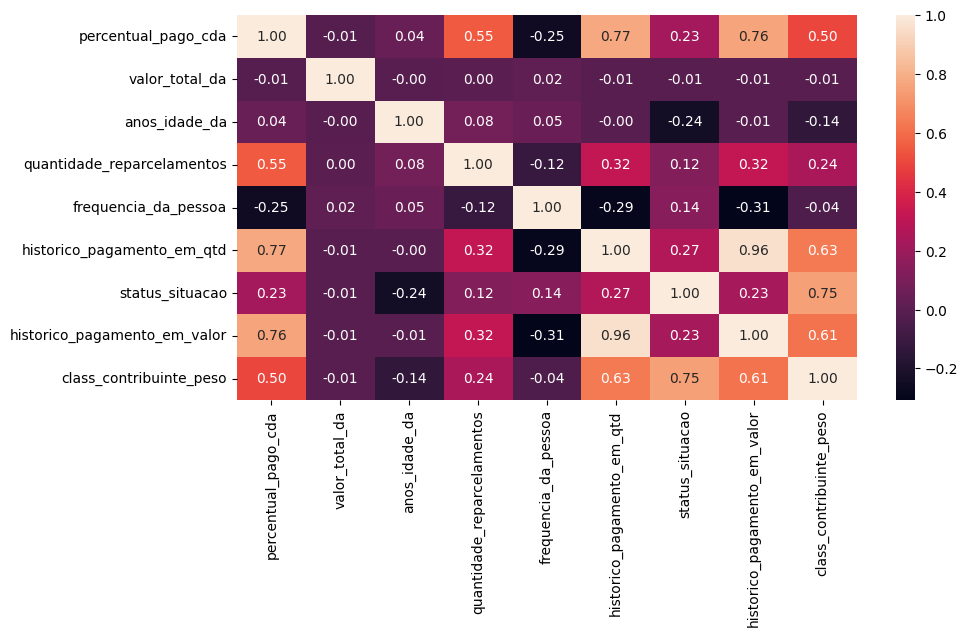

In [20]:
plt.figure(figsize=(10,5))
sns.heatmap(matriz_correlacao, annot = True, fmt = ".2f")
plt.show()

# 04) Definindo pipeline de treinamento dos modelos

In [21]:
seed = 1337 # Semente fixando a aleatoridade dos experimentos

In [22]:
y = df_feature_store['percentual_pago_cda']
x = df_feature_store.drop(columns=['percentual_pago_cda'])

X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=seed, test_size=0.3)

In [23]:
def roda_pipeline(algoritimo_normalizador, algoritimo_regressao, X_train, y_train, X_test, y_test):

    pipeline = Pipeline([('scaler', algoritimo_normalizador), ('regressor', algoritimo_regressao)])
    pipeline.fit(X_train, y_train)

    previsoes = pipeline.predict(X_test)

    r2 = r2_score(y_test, previsoes)
    mse = mean_squared_error(y_test, previsoes)
    
    print("\nModelo treinado:", str(algoritimo_regressao))
    print("R2 ->", r2)
    print("MSE ->", mse)

In [24]:
biblioteca_modelos = {
    'dummy': DummyRegressor(), # Dados dummy - Usado para baseline
    'random_forest': RandomForestRegressor(random_state=seed)
}

pipeline_modelos = ['dummy','random_forest']

# 05) Executando o experimento de treinamento do modelo

In [106]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= StandardScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -1.1616646147238896e-06
MSE -> 0.1463074773155496

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.8693114995780613
MSE -> 0.019120682599065596


In [107]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= MinMaxScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -1.1616646147238896e-06
MSE -> 0.1463074773155496

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.868636663776757
MSE -> 0.019219416008061548


In [108]:
for modelos in pipeline_modelos:
    roda_pipeline(
        algoritimo_normalizador= RobustScaler(),
        algoritimo_regressao= biblioteca_modelos.get(modelos), 
        X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test
    )


Modelo treinado: DummyRegressor()
R2 -> -1.1616646147238896e-06
MSE -> 0.1463074773155496

Modelo treinado: RandomForestRegressor(random_state=1337)
R2 -> 0.8692570350073454
MSE -> 0.019128651163753316


**Conclusão:** 
- Melhor modelo apresenta MSE menor que o Dummy
- A normalização pelo método RobustScale se provou ser a mais robusta
- O modelo apresenta pouca variáção do MSE ao acrescentar ou retirar variáveis, enquanto o R2 ajustado aumenta com a quantidade de variáveis

# 06) Realizando previsões com o melhor modelo

In [25]:
normalizador = StandardScaler()
normalizador.fit(x)
dados_normalizados = normalizador.fit_transform(x)

colunas = list(normalizador.get_feature_names_out())
df_normalizado = pd.DataFrame(dados_normalizados, columns=colunas)

In [26]:
x_norm = df_normalizado

In [27]:
X_train, X_test, y_train, y_test = train_test_split(x_norm, y, random_state=seed, test_size=0.3)

In [28]:
best_model = RandomForestRegressor(random_state=seed)
best_model.fit(X_train, y_train)

RandomForestRegressor(random_state=1337)

In [29]:
predict_test = best_model.predict(X_test)

r2 = r2_score(y_test, predict_test)
mse = mean_squared_error(y_test, predict_test)

print("Métricas de validação do modelo:")
print("R2 ->", r2)
print("MSE ->", mse)

Métricas de validação do modelo:
R2 -> 0.8692512515831596
MSE -> 0.019129497320973233


In [30]:
best_model.get_params() # Parâmetros utilizados

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1337,
 'verbose': 0,
 'warm_start': False}

In [31]:
variaveis_preditoras = best_model.feature_names_in_
importancia_variaveis = best_model.feature_importances_

print("Variáveis preditoras:")
print('\n', variaveis_preditoras)

Variáveis preditoras:

 ['valor_total_da' 'anos_idade_da' 'quantidade_reparcelamentos'
 'frequencia_da_pessoa' 'historico_pagamento_em_qtd' 'status_situacao'
 'historico_pagamento_em_valor' 'class_contribuinte_peso']


In [32]:
dados_features = {
    'features': variaveis_preditoras,
    'importancia': importancia_variaveis
}
matriz_importancia = pd.DataFrame(dados_features).sort_values('importancia', ascending=False).reset_index(drop='index')
matriz_importancia

,features,importancia
0,historico_pagamento_em_qtd,0.606090
1,quantidade_reparcelamentos,0.172882
2,valor_total_da,0.089457
3,historico_pagamento_em_valor,0.073546
4,anos_idade_da,0.029081
5,frequencia_da_pessoa,0.021448
6,status_situacao,0.004703
7,class_contribuinte_peso,0.002794


In [33]:
# Realizando predições para avaliações do modelo

previsoes_norm = best_model.predict(x_norm)

In [34]:
# Gerando resíduos da predição (observado - previsão)
df_feature_store['y_predict'] = previsoes_norm
df_feature_store['residuos'] =  df_feature_store['percentual_pago_cda'] - df_feature_store['y_predict']

In [35]:
# chunk de check luan e larissa
df_feature_store['y_predict'].describe()

count    1.297640e+06
mean     1.412899e-01
std      3.635092e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e-02
max      1.859879e+00
Name: y_predict, dtype: float64

In [36]:
df_feature_store['percentual_pago_cda'].describe()

count    1.297640e+06
mean     1.411839e-01
std      3.822790e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.062816e+00
Name: percentual_pago_cda, dtype: float64

In [121]:
def paste_intervalo(row):

    return "[" + str(row['inf']) + ", " + str(row['sup']) + ")"

data_percentil = {
    'inf': [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1],
    'sup': [0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
}

# Creating a DataFrame from the dictionary

df_cut_percentil = pd.DataFrame(data_percentil)
df_cut_percentil['intervalo'] = df_cut_percentil.apply(paste_intervalo, axis = 1)

# Define the bins and labels for groups
igr_bins = [0, 0.01, 0.25, 0.5, 0.75, 0.99, 1, 1.01]
igr_labels = df_cut_percentil['intervalo']
 
df['percentual_pago_cda_faixas'] = pd.cut(df['percentual_pago_cda'],
                                bins = igr_bins,
                                labels = igr_labels,
                                right = False)

df_metrics = df.groupby('percentual_pago_cda_faixas')['percentual_pago_cda_faixas'].count().to_frame()
total = df_metrics['percentual_pago_cda_faixas'].sum()  
df_metrics['perc'] = df_metrics['percentual_pago_cda_faixas']/total
df_metrics

,percentual_pago_cda_faixas,perc
percentual_pago_cda_faixas,,
"[0.0, 0.01)",1094361,8.746631e-01
"[0.01, 0.25)",41890,3.348039e-02
"[0.25, 0.5)",9385,7.500919e-03
"[0.5, 0.75)",1381,1.103758e-03
"[0.75, 0.99)",1,7.992455e-07
"[0.99, 1.0)",0,0.000000e+00
"[1.0, 1.01)",104162,8.325101e-02


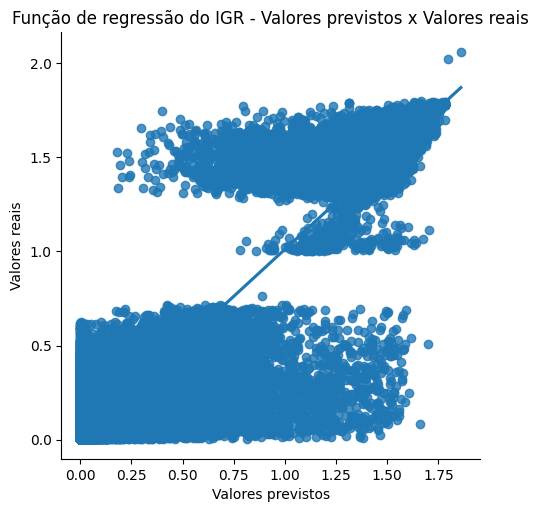

In [122]:
df_regerssao = df_feature_store.query("percentual_pago_cda != 1").query("percentual_pago_cda != 0")

sns.lmplot(x='y_predict' , y='percentual_pago_cda', data=df_regerssao)

plt.title("Função de regressão do IGR - Valores previstos x Valores reais")
plt.xlabel("Valores previstos")
plt.ylabel("Valores reais")

plt.show()

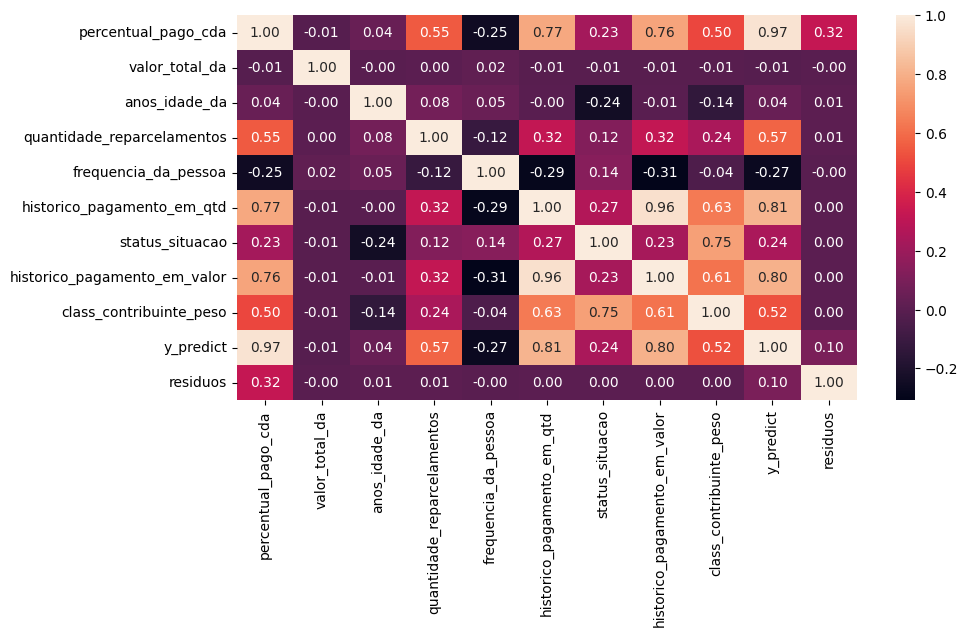

In [123]:
matriz_corr_regressao = df_feature_store.corr()
plt.figure(figsize=(10,5))
sns.heatmap(matriz_corr_regressao, annot = True, fmt = ".2f")
plt.show()

In [124]:
sns.displot(x='residuos', data=df_feature_store)

plt.title("Histograma dos residuos")
plt.xlabel("Residuos")
plt.ylabel("Densidade")
plt.show()

# 07) Salvando o melhor modelo

In [37]:
def salva_modelo_serializado(nome_modelo_serializado, modelo):
    sav_best_model = open(nome_modelo_serializado, 'wb')
    pickle.dump(modelo, sav_best_model)
    sav_best_model.close()

    pathModelo = modelsPath+"\\"+os.path.join(nome_modelo_serializado)
    shutil.move(os.path.abspath(nome_modelo_serializado), pathModelo)

In [38]:
salva_modelo_serializado("modeloDA-igr-divida-v2.pkl", best_model)